In [1]:
import os
from glob import glob
import numpy as np
import fitsio
from scipy.ndimage import gaussian_filter1d
from matplotlib import pyplot as plt
from time import time
from scipy.interpolate import interp1d
from astropy.io import fits
import pandas as pd
from astropy.cosmology import Planck18

In [2]:
# Constructing the file path
file = '/pscratch/sd/z/zhaozhon/desi-ztf-qso-iron-pernight-summary.fits'
files_open = fits.open(file)

In [3]:
all_flux_r = files_open[1].data['FLUX_R']
all_flux_g = files_open[1].data['FLUX_G']
all_EBV = files_open[1].data['EBV']
all_EFFTIME_SPEC = files_open[1].data['EFFTIME_SPEC']
all_COADD_FIBERSTATUS = files_open[1].data['COADD_FIBERSTATUS']
all_z = files_open[2].data['Z']
all_targetids = files_open[2].data['TARGETID']

In [4]:
indice1 = (800 < all_EFFTIME_SPEC)&(all_EFFTIME_SPEC < 1200)
all_flux_r = all_flux_r[indice1]
all_flux_g = all_flux_g[indice1]
all_EBV = all_EBV[indice1]
all_EFFTIME_SPEC = all_EFFTIME_SPEC[indice1]
all_COADD_FIBERSTATUS = all_COADD_FIBERSTATUS[indice1]
all_z = all_z[indice1]
all_targetids = all_targetids[indice1]

In [5]:
indice2 = all_COADD_FIBERSTATUS == 0
all_flux_r = all_flux_r[indice2]
all_flux_g = all_flux_g[indice2]
all_EBV = all_EBV[indice2]
all_EFFTIME_SPEC = all_EFFTIME_SPEC[indice2]
all_COADD_FIBERSTATUS = all_COADD_FIBERSTATUS[indice2]
all_z = all_z[indice2]
all_targetids = all_targetids[indice2]

In [6]:
indice3 = (all_z > 2.1) & (all_z <2.8)
all_flux_r = all_flux_r[indice3]
all_flux_g = all_flux_g[indice3]
all_EBV = all_EBV[indice3]
all_EFFTIME_SPEC = all_EFFTIME_SPEC[indice3]
all_COADD_FIBERSTATUS = all_COADD_FIBERSTATUS[indice3]
all_z = all_z[indice3]
all_targetids = all_targetids[indice3]

In [7]:
all_d = Planck18.distmod(all_z).value

In [8]:
all_app_mag_r = 22.5 - 2.5 * np.log10 ( all_flux_r ) - 2.165 * all_EBV
all_app_mag_g = 22.5 - 2.5 * np.log10 ( all_flux_g ) - 2.165 * all_EBV

In [9]:
DECam_g = np.loadtxt('/pscratch/sd/r/raichoor/desi-ztf-qso/decam-filters/CTIO_DECam.g.dat')
ws_g = DECam_g[:,0]
bp_g = DECam_g[:,1]

In [10]:
DECam_r = np.loadtxt('/pscratch/sd/r/raichoor/desi-ztf-qso/decam-filters/CTIO_DECam.r.dat')
ws_r = DECam_r[:,0]
bp_r = DECam_r[:,1]

In [11]:
tid = 39627533204853360
ardir = os.path.join(os.getenv("PSCRATCH", "/pscratch/sd/z/zhaozhon"))
def get_ws(ardir):
    fn = sorted(
        glob(os.path.join(ardir, "pernight-spectra","desi-ztf-qso-iron-*-*.fits"))
    )[0]
    ws = fitsio.read(fn, "BRZ_WAVE")
    return ws
def get_tid_tileids_nights(tid, all_tids, all_tileids, all_nights):
    sel = all_tids == tid
    return all_tileids[sel], all_nights[sel]
def get_indiv_spectra(tid, tileids, nights, ardir, nwave):

    nobs = len(tileids)

    # read the spectra
    fs = np.zeros((nobs, nwave))  # flux
    ivs = np.zeros((nobs, nwave))  # inverse variance

    # loop on (tileids, nights)
    for i, (tileid, night) in enumerate(zip(tileids, nights)):

        fn = os.path.join(
            ardir,"pernight-spectra",
            "desi-ztf-qso-iron-{}-{}.fits".format(tileid, night),
        )

        # first get the row corresponding to TARGETID
        # (for a given TILEID, a TARGETID can appear only once max.)
        tmp_fm = fitsio.read(fn, "FIBERMAP", columns=["TARGETID"])
        tmp_i = np.where(tmp_fm["TARGETID"] == tid)[0][0]

        # now read the flux, ivar only for that row

        # this is more intuitive, but it loads the whole image first,
        #   then extracts the relevant row, so it s ~slow
        fs[i, :] = fitsio.read(fn, "BRZ_FLUX")[tmp_i, :]
        ivs[i, :] = fitsio.read(fn, "BRZ_IVAR")[tmp_i, :]

        # this way is *much* faster, with reading only the relevant row
        #   note: fitsio wants/works with a slice, not an integer...
        #h = fitsio.FITS(fn)
        #tmp_slice = slice(tmp_i, tmp_i + 1, 1)
        #fs[i, :] = h["BRZ_FLUX"][tmp_slice, :]
        #ivs[i, :] = h["BRZ_IVAR"][tmp_slice, :]

    return fs, ivs
def get_smooth(fs, ivs, gauss_smooth):
    tmp0fs = fs.copy()
    tmp0fs[ivs == 0] = 0
    tmp1fs = 1 + 0 * fs.copy()
    tmp1fs[ivs == 0] = 0
    tmp0smfs = gaussian_filter1d(tmp0fs, gauss_smooth, mode="constant", cval=0)
    tmp1smfs = gaussian_filter1d(tmp1fs, gauss_smooth, mode="constant", cval=0)
    return tmp0smfs / tmp1smfs
def plot_tid_spectra(outpng, tid, ws, fs, ivs):
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(fs.shape[0]):
        smfs_i = get_smooth(fs[i], ivs[i], 5)
        ax.plot(ws, smfs_i, lw=0.5)
    ax.set_title("TARGETID = {}".format(tid))
    ax.set_xlabel("Observed wavelength [A]")
    ax.set_ylabel("Flux [erg / cm2 / s / A]")
    ax.grid()
    plt.savefig(outpng, bbox_inches="tight")
    plt.close()
sumfn = os.path.join(ardir, "desi-ztf-qso-iron-pernight-summary.fits")
def save_wavelength_and_flux_to_npy(wavelength, flux, filename1,filename2):
    np.save(filename1, wavelength)
    np.save(filename2,flux)
def k_correction(ws,fs,ws_bp,bp,z0,z1,x_l,x_r):
    fs_avg = np.mean(fs, axis=0)
    f = interp1d(ws,fs_avg, kind='cubic')
    f_bp = interp1d(ws_bp, bp, kind='cubic')
    #area0
    new_ws = np.linspace(ws_bp[0],ws_bp[-1],10000)
    new_fs = f(new_ws)
    new_bp = f_bp(new_ws)
    y_0 = new_ws*new_fs*new_bp
    area0 = np.trapz(y_0,new_ws)
    #area1
    new_ws1 = np.linspace(ws_bp[0]/(1+z0),ws_bp[-1]/(1+z0),10000)
    new_fs1 = f(new_ws1*(1+z1))
    y_1 = new_ws1*new_fs1*new_bp
    area1 = np.trapz(y_1,new_ws1)
    k = 5*np.log10(1+z1)+2.5*np.log10(area1/area0)
    #if 2.1<z1<2.9:       
        #plt.plot(new_ws1,new_fs1)
        #plt.plot(new_ws1,new_bp)
        #plt.show()
    #zero_point
    #area2 = np.trapz(f_z(new_ws)*new_ws*new_bp,new_ws)
    #area3 = np.trapz(f_z(new_ws1*(1+z1))*new_ws1*new_bp,new_ws1)
    #k = 2.5*np.log10(1+z1)+2.5*np.log10(area1/area0)+2.5*np.log10(area2/area3)
    return k
# wavelengths
ws = get_ws(ardir)
nwave = len(ws)

# read the master table
start = time()
d = fitsio.read(sumfn, "FIBERMAP")
print("reading {} done (took {:.1f}s)".format(sumfn, time() - start))

# get the (TILEID,NIGHT) sets for that TARGETID
tileids, nights = get_tid_tileids_nights(tid, d["TARGETID"], d["TILEID"], d["NIGHT"])

# get fluxes and ivars
start = time()
fs, ivs = get_indiv_spectra(tid, tileids, nights, ardir, nwave)
print("done extracting {} spectra for TARGETID={} (took {:.1f}s)".format(len(tileids), tid, time() - start))

reading /pscratch/sd/z/zhaozhon/desi-ztf-qso-iron-pernight-summary.fits done (took 2.0s)
done extracting 4 spectra for TARGETID=39627533204853360 (took 0.6s)


In [12]:
print(ws[0],ws[-1])

3600.0 9824.000000000524


In [13]:
from tqdm import tqdm
k_g_desi = []
for index,targetid in tqdm(enumerate(all_targetids),total = 400881):
    z_1 = all_z[index]
    ws = get_ws(ardir)
    nwave = len(ws)
    tileids, nights = get_tid_tileids_nights(targetid, d["TARGETID"], d["TILEID"], d["NIGHT"])
    fs, ivs = get_indiv_spectra(targetid, tileids, nights, ardir, nwave)
    k = k_correction(ws,fs,ws_g,bp_g,2.05,z_1,ws_g[0],ws_g[-1])
    k_g_desi.append(k)

 11%|█         | 43411/400881 [2:01:33<12:09:36,  8.17it/s]/tmp/ipykernel_951663/1748024826.py:86: RuntimeWarning: invalid value encountered in log10
  k = 5*np.log10(1+z1)+2.5*np.log10(area1/area0)
 69%|██████▉   | 277858/400881 [11:57:30<4:28:32,  7.64it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 400881/400881 [17:29:40<00:00,  6.37it/s]   


In [14]:
np.save('k_g_desi',k_g_desi)

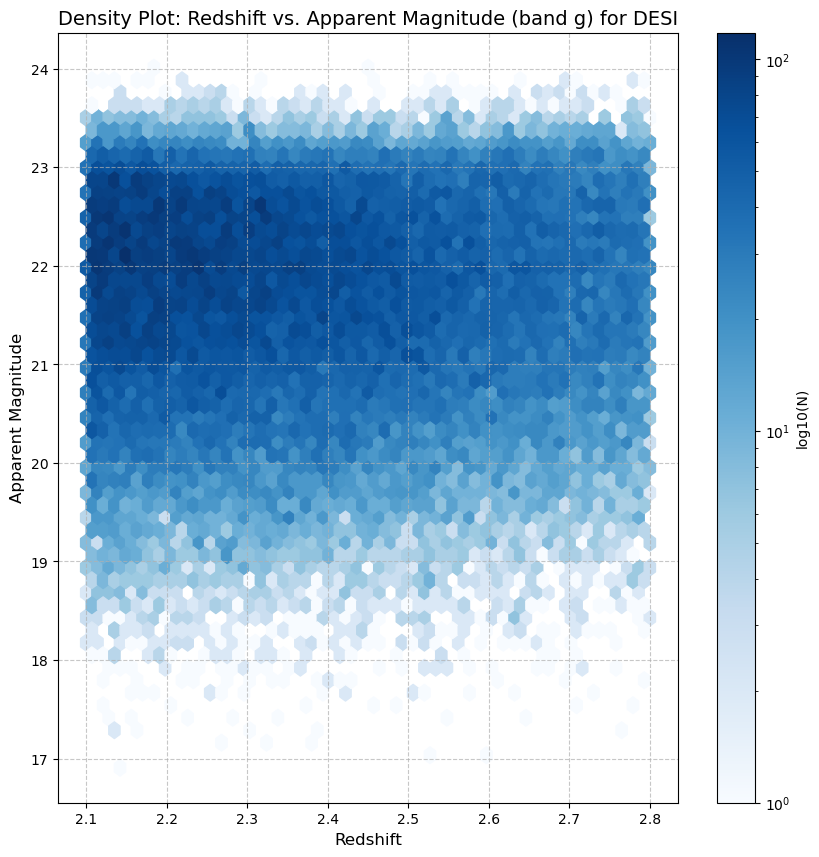

In [15]:
plt.figure(figsize=(10, 10))
plt.hexbin(all_z[:68274], all_app_mag_g[:68274], gridsize=50, cmap='Blues', bins='log')
plt.colorbar(label='log10(N)')
plt.title('Density Plot: Redshift vs. Apparent Magnitude (band g) for DESI', fontsize=14)
plt.xlabel('Redshift', fontsize=12)
plt.ylabel('Apparent Magnitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('/global/u1/z/zhaozhon/k-correction/plot/apr_mag_density_desi', dpi=300) 

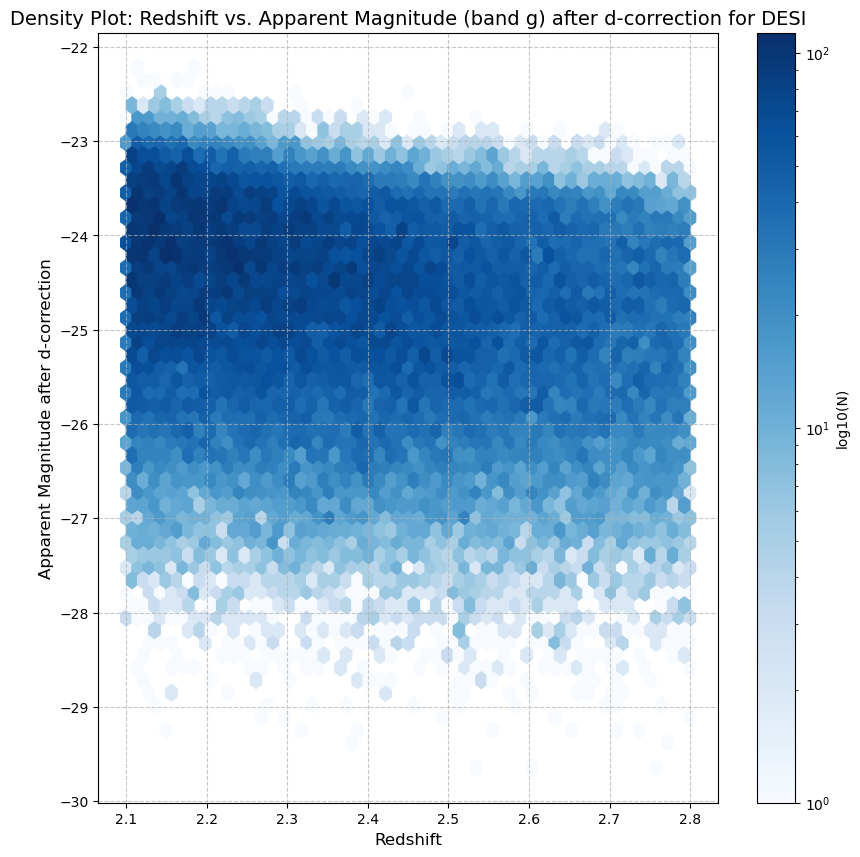

In [16]:
plt.figure(figsize=(10, 10))
plt.hexbin(all_z[:68274], all_app_mag_g[:68274] - all_d[:68274], gridsize=50, cmap='Blues', bins='log')
plt.colorbar(label='log10(N)')
plt.title('Density Plot: Redshift vs. Apparent Magnitude (band g) after d-correction for DESI', fontsize=14)
plt.xlabel('Redshift', fontsize=12)
plt.ylabel('Apparent Magnitude after d-correction', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('/global/u1/z/zhaozhon/k-correction/plot/apr_d_mag_density_desi', dpi=300) 

In [17]:
plt.figure(figsize=(10, 10))
plt.hexbin(all_z[:68274], all_app_mag_g[:68274] - all_d[:68274] - k_g_desi, gridsize=50, cmap='Blues', bins='log')
plt.colorbar(label='log10(N)')
plt.title('Density Plot: Redshift vs. Absolute Magnitude (band g) for DESI', fontsize=14)
plt.xlabel('Redshift', fontsize=12)
plt.ylabel('Absolute Magnitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('/global/u1/z/zhaozhon/k-correction/plot/abs_mag_density_desi', dpi=300) 

ValueError: operands could not be broadcast together with shapes (68274,) (400881,) 

<Figure size 1000x1000 with 0 Axes>

In [ ]:
from tqdm import tqdm
k_r_desi = []
for index,targetid in tqdm(enumerate(all_targetids),total = 400881):
    z_1 = all_z[index]
    ws = get_ws(ardir)
    nwave = len(ws)
    tileids, nights = get_tid_tileids_nights(targetid, d["TARGETID"], d["TILEID"], d["NIGHT"])
    fs, ivs = get_indiv_spectra(targetid, tileids, nights, ardir, nwave)
    k = k_correction(ws,fs,ws_r,bp_r,2.1,z_1,ws_r[0],ws_r[-1])
    k_r_desi.append(k)

In [ ]:
np.save('k_r_desi',k_r_desi)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
indice = all_snr > 1

# Set the size of the figure
plt.figure(figsize=(10, 8))  # Width, Height in inches

# Create the scatter plot
plt.scatter(all_z, 22.5 - 2.5 * np.log10 ( all_flux_r ) - 2.165 * all_EBV , s=40)  # 's' sets the size of each point

# Optionally, set larger labels and title, if needed
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('App_magnitude_r', fontsize=14)
plt.title('Apparent Magnitude(R band)  vs. Redshift', fontsize=16)

# If you want to adjust the size of the tick labels:
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Set the size of the figure
plt.figure(figsize=(10, 8))  # Width, Height in inches

# Create the scatter plot
plt.scatter(all_z, np.log(all_snr), s=40)  # 's' sets the size of each point

# Optionally, set larger labels and title, if needed
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Signal-to-Noise Ratio (SNR)(R band)', fontsize=14)
plt.title('SNR vs. Redshift(R band)', fontsize=16)
# If you want to adjust the size of the tick labels:
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [ ]:
indice = all_snr > 10

plt.figure(figsize=(10, 8))  # Width, Height in inches

# Create the scatter plot
plt.scatter(all_z[indice], all_snr[indice], s=40)  # 's' sets the size of each point

# Optionally, set larger labels and title, if needed
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Signal-to-Noise Ratio (SNR)(R band)', fontsize=14)
plt.title('SNR vs. Redshift(R band)', fontsize=16)

# If you want to adjust the size of the tick labels:
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [ ]:
indice = all_snr > 0
plt.figure(figsize=(20, 8))
plt.hexbin(all_flux_r[indice], np.log(all_snr[indice]), gridsize=100, cmap='Blues')
plt.colorbar(label='Density')
plt.xlabel('flux_r')
plt.ylabel('Signal-to-Noise Ratio (SNR)(R band)')
plt.title('Density of SNR vs flux(R band)')
plt.ylim(-3,5)
plt.xlim(0,50)
plt.axhline(np.log10(3), color="r")
plt.grid()
plt.show()

In [ ]:
indice = all_snr > 0
plt.figure(figsize=(20, 8))
plt.hexbin(all_z[indice], np.log(all_snr[indice]), gridsize=100, cmap='Blues')
plt.colorbar(label='Density')
plt.xlabel('Redshift (z)')
plt.ylabel('Signal-to-Noise Ratio (SNR)(Band R)')
plt.title('Density of SNR vs Redshift(Band R)')
plt.ylim(-3,5)
plt.axhline(np.log10(3), color="r")
plt.grid()
plt.show()

In [ ]:
import seaborn as sns

# Create a figure with two subplots (one for each distribution)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Histogram for SNR
sns.histplot(all_snr, kde=True, ax=axs[0], color="skyblue", bins=1000)
axs[0].set_title('Distribution of Signal-to-Noise Ratio (SNR)(Band R)')
axs[0].set_xlabel('SNR')
axs[0].set_ylabel('Frequency(Band R)')

# Histogram for Redshift
sns.histplot(all_z, kde=True, ax=axs[1], color="salmon", bins=1000)
axs[1].set_title('Distribution of Redshift (z)(Band R)')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_ylabel('Frequency(Band R)')

# Automatically adjust the subplot params for better layout
plt.tight_layout()

# Show the plot
plt.show()